In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET
import time
import json
import tarfile
import gzip
import os

from data_preprocessing import * 
from imdb_ratings_scraper import *
import load_functions as lf


# Load data

## Movie Summaries

In [5]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# add release year (float) to movie_metadata, extracting it from release_date
movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add lowecase title to movie_metadata
movie_metadata['lowercase_title'] = movie_metadata['movie_name'].str.lower()

# add release year (float) to character_metadata, extracting it from release_date
character_metadata['release_year'] = character_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add actor birth year (float) to character_metadata, extracting it from actor_birth_date
character_metadata['actor_birth_year'] = character_metadata['actor_birth_date'].apply(lambda x: lf.extract_year(x))

Metadata for 81 741 movies, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
10. Movie release year
11. Lowercase title

In [6]:
movie_metadata.head()

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,ghosts of mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,getting away with murder: the jonbenét ramsey ...
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,brun bitter
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,white of the eye
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,a woman in flames


Metadata for 450 669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
14. Release year
15. Actor birth year

In [7]:
character_metadata.head()

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,1977.0


Plot summaries of 42 303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie_metadata) followed by the summary.

In [8]:
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


# Basic features analysis

## Undestanding the dataset

In [9]:
print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())
print('\nnumber of rows in movie_metadata:',movie_metadata.shape[0])

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
release_year           6902
lowercase_title           0
dtype: int64

number of rows in movie_metadata: 81741


In [10]:
print('number of nan values in character_metadata:')
print(character_metadata.isna().sum())
print('\nnumber of character_metadata rows:', character_metadata.shape[0])

number of nan values in character_metadata:
wiki_movie_id                       0
free_movie_id                       0
release_date                     9995
character_name                 257875
actor_birth_date               106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
free_character_actor_map_id         0
free_character_id              257865
free_actor_id                     815
release_year                     9995
actor_birth_year               106156
dtype: int64

number of character_metadata rows: 450669


In [11]:
print('unique values of freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id'].unique()))
print('freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id']))
print('number of movie ID in character_metadata, which appear in movie_metadata:',
      sum(movie_metadata['free_movie_id'].isin(character_metadata['free_movie_id'].unique())))

unique values of freebase movie ID in character_metadata: 64330
freebase movie ID in character_metadata: 450669
number of movie ID in character_metadata, which appear in movie_metadata: 64330


Each movie in character_metadata appears in movie_metadata

In [12]:
print('unique values of freebase character ID in character_metadata (number of characters):',
      len(character_metadata['free_character_id'].unique()))
print('unique values of freebase actor ID in character_metadata (number of actors):',
      len(character_metadata['free_actor_id'].unique()))
print('unique values of actor ethnicity in character_metadata (number of ethnicities):',
      len(character_metadata['actor_ethnicity'].unique()))

unique values of freebase character ID in character_metadata (number of characters): 183436
unique values of freebase actor ID in character_metadata (number of actors): 135761
unique values of actor ethnicity in character_metadata (number of ethnicities): 480


## Plot data

### Movies metadata

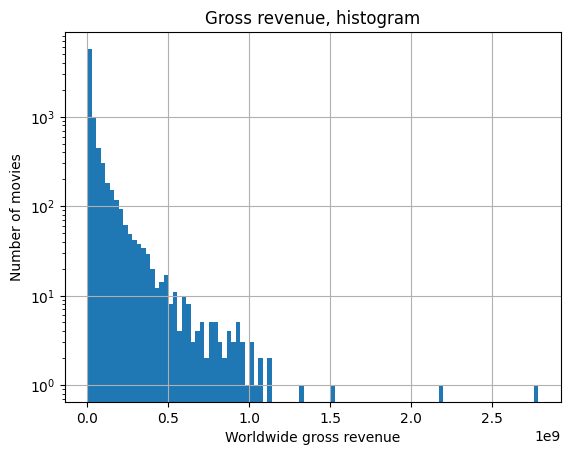

In [13]:
# gross revenue histogram
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

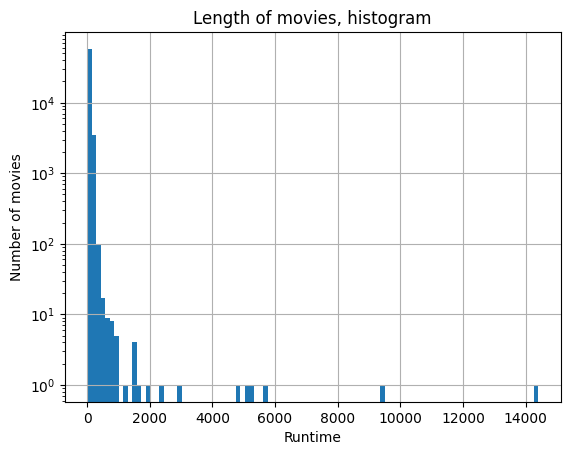

In [14]:
# length of movies histogram.
# We dropped movies with a length >= 1079280, as we observed errors in the dataset
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

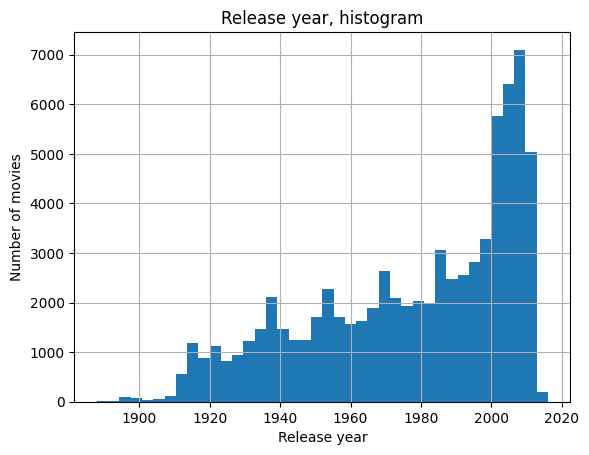

In [15]:
# release year histogram. We dropped movies with a release year <= 1011,
# We dropped movies with a release year <= 1011, as we observed errors in the dataset
movie_metadata[movie_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

### Characters metadata

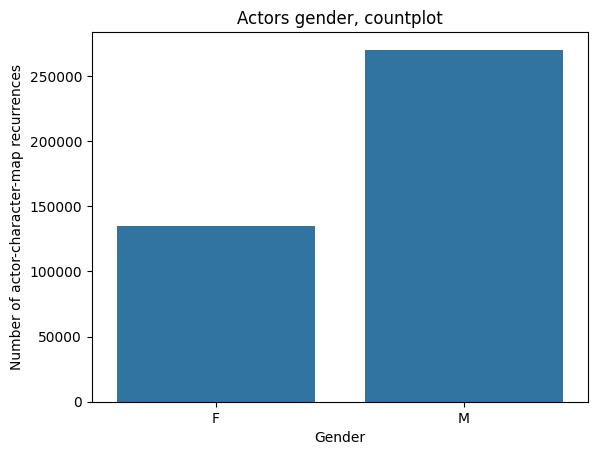

In [16]:
# actor gender countplot
sns.countplot(data=character_metadata, x="actor_gender");
plt.title('Actors gender, countplot')
plt.xlabel('Gender')
plt.ylabel('Number of actor-character-map recurrences');

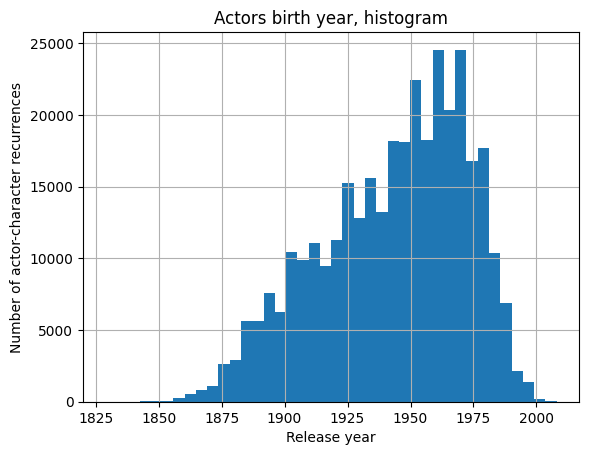

In [17]:
# actor birth year, histogram
# We dropped actors with a birth year <= 1828 or >= 2009, as we observed errors in the dataset
character_metadata[(character_metadata['actor_birth_year'] > 1828) * (character_metadata['actor_birth_year'] < 2009)].actor_birth_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors birth year, histogram');

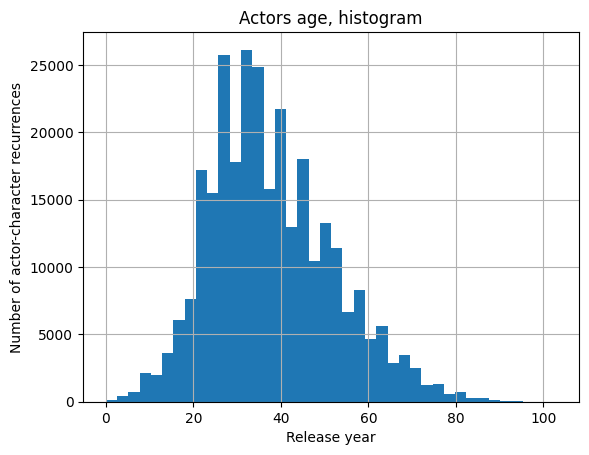

In [18]:
# actor age histogram
# We dropped actors with an age < 0, as we observed errors in the dataset
character_metadata[character_metadata['actor_age'] >= 0].actor_age.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors age, histogram');

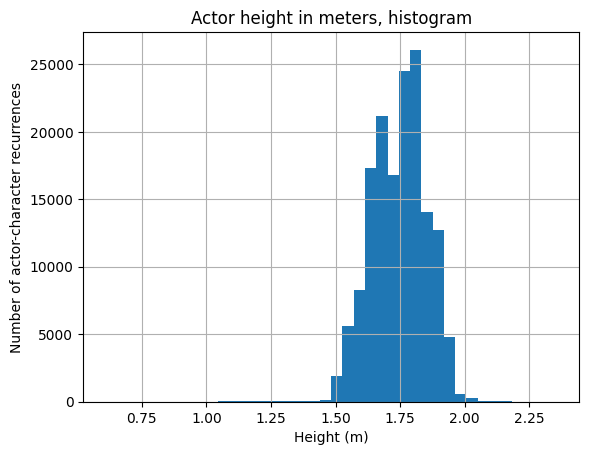

In [19]:
# actor height histogram
# We dropped actors with a height >= 3, as we observed errors in the dataset
character_metadata[character_metadata['actor_height'] < 3].actor_height.dropna().hist(bins = 40, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

# Plot evolution and similarity


In [20]:
from similarity_and_evolution import preprocess_text, cosine_similarity

plot_similarity = plot_summaries
plot_evolution = plot_summaries
plot_similarity['count_words'] = plot_similarity.apply(lambda x: len(str(x['plot']).split()), axis=1)

# Drop plots with less than 200 words
plot_similarity.drop(plot_similarity[plot_similarity['count_words'] < 200].index, inplace= True)

# Preprocess the synopses
# The Hunger Games
preprocessed_synopsis1 = preprocess_text(plot_similarity.query("wiki_movie_id == 31186339").iloc[0]['plot'])

# Fast and Furious: Tokyo Drift
preprocessed_synopsis2 = preprocess_text(plot_similarity.query("wiki_movie_id == 2913859").iloc[0]['plot'])

# Harry Potter: Deathly Hallows Part I
preprocessed_synopsis3 = preprocess_text(plot_similarity.query("wiki_movie_id == 9834441").iloc[0]['plot'])

# Mamma mia
preprocessed_synopsis4 = preprocess_text(plot_similarity.query("wiki_movie_id == 8425661").iloc[0]['plot'])

Compute cosine similarity between preprocessed plots

In [21]:
similarity_1 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis2)
similarity_2 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis3)
similarity_3 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis4)
similarity_4 = cosine_similarity(preprocessed_synopsis3, preprocessed_synopsis4)

### Cosine similarity interpretation and validation
If cosine similarity is equal to 1 means both plots are identical. On the other side, if cosine similarity is equal to 0 means the plots have nothing in common.

Overviewing the below similarities, it makes sense that "The Hunger Games" is more similar to a film such as "Harry Potter: Deathly Hallows Part 1" for more common actions such as "kill", "reveal" and "take" than to Fast&Furious and Mamma Mia. This actions may appear also in the latter movies but with less relevance.

And unusual phenomena is observed when comparing Harry Potter to Mamma Mia. Using the user's experience, one can argue these films are not very much alike. Investigating the issue further, we discover that this high value on similarity is due to one of the main protagonist for both films are called Harry.

Filtering people's name might be necessary to refine the algorithm.

In [22]:
print(f"Cosine Similarity The Hunger Games - F&F:Tokyo Drift: {similarity_1}")
print(f"Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: {similarity_2}")
print(f"Cosine Similarity The Hunger Games - Mamma mia: {similarity_3}")
print(f"Cosine Similarity HP: Death Hollows P1 - Mamma mia: {similarity_4}")

Cosine Similarity The Hunger Games - F&F:Tokyo Drift: 0.029112649379961022
Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: 0.0582765471839679
Cosine Similarity The Hunger Games - Mamma mia: 0.029958426421823198
Cosine Similarity HP: Death Hollows P1 - Mamma mia: 0.033301144786951474


### Similarity computation by year
We are interested on how much similar are movies released on the same year are alike

In [23]:
plot_similarity_enriched = pd.merge(plot_similarity, movie_metadata[['movie_name','release_year','wiki_movie_id']], on="wiki_movie_id",how='left')
plot_similarity_enriched.head()

,wiki_movie_id,plot,count_words,movie_name,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,778,The Hunger Games,2012.0
1,20663735,Poovalli Induchoodan is sentenced for six yea...,496,Narasimham,2000.0
2,2231378,"The Lemon Drop Kid , a New York City swindler,...",849,The Lemon Drop Kid,1951.0
3,595909,Seventh-day Adventist Church pastor Michael Ch...,397,A Cry in the Dark,1988.0
4,5272176,The president is on his way to give a speech. ...,344,End Game,2006.0


In [24]:
#similarity_by_year = plot_similarity_enriched.groupby('release_year')
#for year, group in similarity_by_year:
#    for idx, row in group.iterrows():
#        preprocessed_text = preprocess_text(row['plot'])
#        print(preprocessed_text)

### Emotional arc

An interesting aspect of a movie is its emotional arc. We give a sentiment value to each sentence in the plot summary and then interpret the sequence of sentiment values of the sentences as the movie's emotional arc.

In [25]:
from similarity_and_evolution import tokenize_per_sentence
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# The Hunger Games, tokenized per sentence
plot_per_sentence1 = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 31186339").iloc[0]['plot'])
# Fast and Furious: Tokyo Drift, tokenized per sentence
plot_per_sentence2 = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 2913859").iloc[0]['plot'])

In [26]:
analyzer = SentimentIntensityAnalyzer()
"""
    This function computes the sentiment value of each sentence in the plot, and returns all of them as a list.
"""
def compute_sentiment_sequence(plot_sentences):
    sentiment_sequence = []
    for sentence in plot_sentences:
        sentiment_sequence.append(analyzer.polarity_scores(sentence)['compound'])
    return sentiment_sequence

Text(0, 0.5, 'sentiment value')

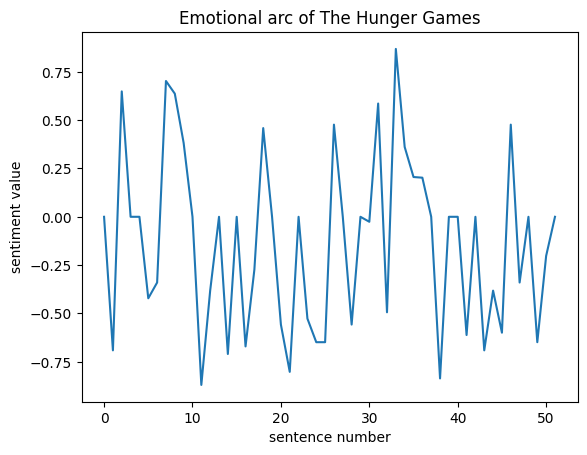

In [49]:
# plot the sentiment value sequence, i.e emotional arc, of the Hunger Games
emotional_arc1 = compute_sentiment_sequence(plot_per_sentence1)
plt.plot(emotional_arc1)
plt.title("Emotional arc of The Hunger Games")
plt.xlabel("sentence number")
plt.ylabel("sentiment value")

To take the average over different emotional arcs of movies, there is one problem. They are of different length. We circumvent this problem by normalizing all emotional arcs to one length, namely the average length of all emotional arcs.

Text(0, 0.5, 'sentiment value')

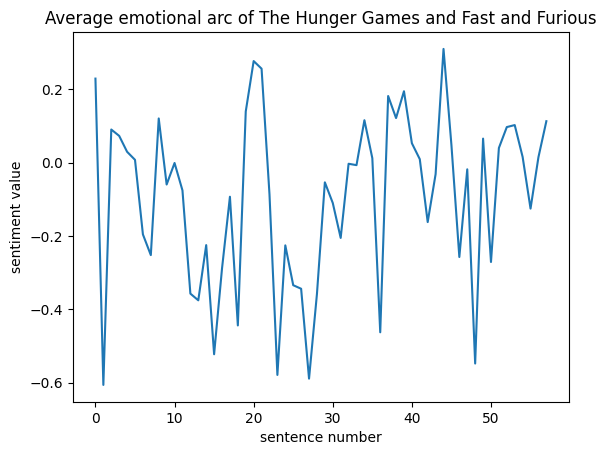

In [50]:
from scipy.interpolate import interp1d
import statistics
# compute emotional arc of Fast and Furious
emotional_arc2 = compute_sentiment_sequence(plot_per_sentence2)

# compute the length to which we normalize both sequences as the average of the two lengths
normalized_length = round(sum([len(emotional_arc1), len(emotional_arc2)])/2)

# normalize both sequences to this lenght using interpolation
interpolate1 = interp1d(np.linspace(0, 1, len(emotional_arc1)), emotional_arc1)
interpolate2 = interp1d(np.linspace(0, 1, len(emotional_arc2)), emotional_arc2)
emotional_arc2_norm = interpolate2(np.linspace(0, 1, normalized_length))
emotional_arc1_norm = interpolate1(np.linspace(0, 1, normalized_length))

# compute average emotional arc over these two movies
average_emotional_arc = np.mean([emotional_arc1_norm, emotional_arc2_norm], axis=0)
plt.plot(average_emotional_arc)
plt.title("Average emotional arc of The Hunger Games and Fast and Furious")
plt.xlabel("sentence number")
plt.ylabel("sentiment value")

As we can see that the emotional arcs is not smooth at all, we will still have to apply some smoothing to them to make them more interpretable.

## Regression ratings change over the years

In [100]:
# only run if want to scrpae new data 
number_elements_to_scrape = len(res)

ratings_df = pd.DataFrame()

for index, row in res.iloc[:number_elements_to_scrape].iterrows():

    print(f"{index}/{number_elements_to_scrape} scraped -- Now scraping {row['tconst']}", end = '\r')

    try: 
        dates, ratings, num_voters = scraper_review_next_and_five_years(row['tconst'], row['release date'])
        ratings.extend(num_voters)
        df = pd.DataFrame([ratings], columns=['after_one_year_rating', 'after_five_year_rating', 'one_year_num_voters', 'five_year_num_voters',], index = [row['tconst']])
        ratings_df = pd.concat([df, ratings_df],  sort=False)
        # df = pd.DataFrame([num_voters], columns=['first_date', 'second_date'], index = [row['tconst'] ])
        # num_voters_df = pd.concat([df, num_voters_df],  sort=False)
    except Exception as e: 
        print(f"Exception {e}")  # handling all excpetion in order to not sto pscraping process

# print(result_df.head())
ratings_df.to_csv('data/imbd_ratings.csv') # save scraped for future use

Unable to retrieve data for  (20100817): exception 'NoneType' object has no attribute 'group'
couldn't scrape for 20100817: exception not enough values to unpack (expected 2, got 0)
Exception 4 columns passed, passed data had 2 columns
Unable to retrieve data for  (20100205): exception 'NoneType' object has no attribute 'group'
couldn't scrape for 20100205: exception not enough values to unpack (expected 2, got 0)
Exception 4 columns passed, passed data had 2 columns
Exception 'closest'Now scraping tt0084747
Exception 'closest'Now scraping tt12706514
Exception 'closest'Now scraping tt1407061
couldn't scrape for 20110910: exception not enough values to unpack (expected 2, got 0)
couldn't scrape for 20150909: exception not enough values to unpack (expected 2, got 0)
Exception 4 columns passed, passed data had 0 columns
Exception 'closest'Now scraping tt24221608
couldn't scrape for 20121225: exception not enough values to unpack (expected 2, got 0)
couldn't scrape for 20161224: exception 

In [3]:
# load merged dataset with imdb ids and movie metadata
# loading merged in order to not have two huge dataset in memory
importance_over_time_df = pd.read_csv('data/movies_imdb_ids.csv')

importance_over_time_df['release date'] = pd.to_datetime(importance_over_time_df['release date'], format='%Y-%m-%d') # convert to datetime format
importance_over_time_df = importance_over_time_df.loc[importance_over_time_df['release date']  > datetime(2004, 1, 1)].copy()  # only consider dates after 2004 (before imdb didn't exist)
importance_over_time_df = importance_over_time_df.loc[importance_over_time_df['box office revenue'].notna()].copy() # remove ones without box office revenue
importance_over_time_df.reset_index(inplace=True, drop=True)
importance_over_time_df = importance_over_time_df.loc[:, ~importance_over_time_df.columns.str.contains('^Unnamed')]  # dropping unnamed columns
importance_over_time_df.head(1)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime,languages,countries,genres_x,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y
0,12621957,/m/05pdd86,the sorcerer's apprentice,2010-07-08,215283742.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",tt0048644,short,the sorcerer's apprentice,The Sorcerer's Apprentice,0,1955,\N,13,Short


In [4]:
ratings_df = pd.read_csv('data/imbd_ratings.csv') 
ratings_df = ratings_df.set_index(ratings_df.iloc[:, 0])
ratings_df = ratings_df.loc[:, ~ratings_df.columns.str.contains('^Unnamed')] 

ratings_metadata = importance_over_time_df.merge(ratings_df, how ='right', left_on='tconst', right_index=True)
ratings_metadata.head(1)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime,languages,countries,genres_x,tconst,...,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,after_one_year_rating,after_five_year_rating,one_year_num_voters,five_year_num_voters
2973,4492078,/m/0c5clj,how to eat fried worms,2006-08-25,13040527.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/07s9rl0"": ""Dra...",tt0286703,...,How to Eat Fried Worms,0,1984,\N,\N,"Animation,Family,Short",5.3,6.4,16,23


In [5]:
metadata_df = pd.read_csv('data/movies.csv')

metadata_df.name = metadata_df.name.str.lower()
ratings_metadata.name = ratings_metadata.name.str.lower()

ratings_metadata = ratings_metadata.merge(metadata_df, 'inner', on='name')
ratings_metadata.head(2)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime_x,languages,countries,genres_x,tconst,...,score,votes,director,writer,star,country,budget,gross,company,runtime_y
0,25920477,/m/0b6lqyd,source code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0945513,...,7.5,495000.0,Duncan Jones,Ben Ripley,Jake Gyllenhaal,United States,32000000.0,147332697.0,Summit Entertainment,93.0
1,10149834,/m/02q3fdr,ponyo,2008-07-19,202614288.0,101.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/03k9fj"":...",tt0876563,...,7.7,131000.0,Hayao Miyazaki,Hayao Miyazaki,Cate Blanchett,Japan,34000000.0,204826668.0,Studio Ghibli,101.0


In [6]:
characters_meta = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None,)
characters_meta.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'movie release date', 'Character Name', 'Actor DOB',  'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'Freebase character map', 'boh', 'boh1']
characters_meta.head(2)

,Wikipedia Movie ID,Freebase Movie ID,movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map,boh,boh1
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [7]:
movie_stats = characters_meta.groupby("Freebase Movie ID").agg(
    num_actors=pd.NamedAgg(column="Actor Name", aggfunc="nunique"),
    avg_age=pd.NamedAgg(column="Actor age at movie release", aggfunc="mean"),
    gender_percent=pd.NamedAgg(column="Actor gender", aggfunc=lambda x: (x == "F").sum() / len(x) * 100)
).reset_index()

ratings_metadata = ratings_metadata.merge(movie_stats, 'inner', left_on='Freebase movie ID', right_on='Freebase Movie ID')

In [8]:
def get_first_value_from_dictionary(row, value):
    l = list(json.loads(row[value]).values())
    if len(l) > 0: 
        genres = l[0]
    else: 
        genres = ''
    return genres

def count_dictionary(row, value): 
    return len(json.loads(row[value]).keys())

# extracting values from dictionaries
ratings_metadata["genre"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["language"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
ratings_metadata["country"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
ratings_metadata['year'] = pd.DatetimeIndex(ratings_metadata['release date']).year  # extracting year

ratings_metadata["n_genre"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["n_language"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
ratings_metadata["n_country"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

ratings_metadata['titleType'] = ratings_metadata['titleType'].astype('category').cat.codes
ratings_metadata['company'] = ratings_metadata['company'].astype('category').cat.codes
ratings_metadata['star'] = ratings_metadata['star'].astype('category').cat.codes
ratings_metadata['runtimeMinutes'] = pd.to_numeric(ratings_metadata.runtimeMinutes, errors='coerce')

In [9]:
ratings_metadata.columns

Index(['Wikipedia movie ID', 'Freebase movie ID', 'name', 'release date',
       'box office revenue', 'runtime_x', 'languages', 'countries', 'genres_x',
       'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres_y',
       'after_one_year_rating', 'after_five_year_rating',
       'one_year_num_voters', 'five_year_num_voters', 'rating', 'genre',
       'year', 'released', 'score', 'votes', 'director', 'writer', 'star',
       'country', 'budget', 'gross', 'company', 'runtime_y',
       'Freebase Movie ID', 'num_actors', 'avg_age', 'gender_percent',
       'language', 'n_genre', 'n_language', 'n_country'],
      dtype='object')

/tmp/ipykernel_15618/23892137.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ratings_metadata.ratings_difference =  ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating # TODO: adjust by the number of voters


Text(0.5, 1.0, 'movie rating after one and five year from release')

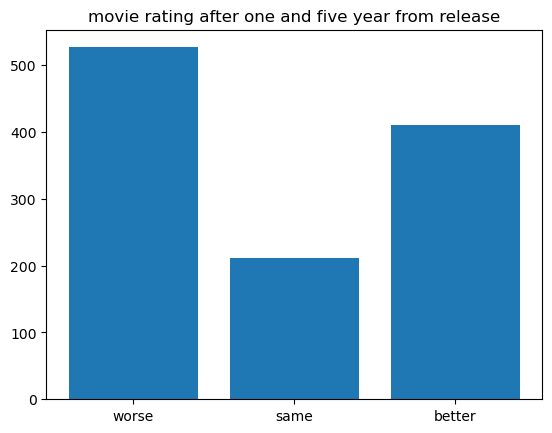

In [10]:
# variable we'll try to predict
ratings_metadata.ratings_difference =  ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating # TODO: adjust by the number of voters

plt.bar(['worse', 'same', 'better'], height=[(ratings_metadata.ratings_difference < 0).sum(), (ratings_metadata.ratings_difference == 0).sum(), (ratings_metadata.ratings_difference > 0).sum()])
plt.title('movie rating after one and five year from release')

In [11]:

y = ratings_metadata.after_five_year_rating
X = ratings_metadata[['box office revenue', 'year', 'runtimeMinutes', 'n_language', 'star', 'n_genre', 
                      'gender_percent', 'num_actors', 'avg_age', 'one_year_num_voters', 'budget', 'company','isAdult', 'after_one_year_rating']].copy()


# X = ratings_metadata[['year', 'after_one_year_rating']].copy()
                      
X.fillna(X.mean(), inplace=True)

X = ((X - X.mean())  / X.std())
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     after_five_year_rating   R-squared:                       0.794
Model:                                OLS   Adj. R-squared:                  0.792
Method:                     Least Squares   F-statistic:                     313.0
Date:                    Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                            21:48:17   Log-Likelihood:                -894.14
No. Observations:                    1149   AIC:                             1818.
Df Residuals:                        1134   BIC:                             1894.
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

The OLS regression fits well the data as the R-squared is high. It shows that there aren't big fluctuation in the ratings after one and five years. The initial rating that a movie recievs it's likely to stay the same for the next years. It is interesting to notice that the year coefficient is positive, this means that in recent years movies tend to get better over time. Other than the initial rating and the year there is no other features which can be usefull in predicting the ratings in five years. 

# Most important features over time

In [24]:
movies_metadata = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None)
movies_metadata.columns = ['wiki id', 'free base id', 'name', 'release date', 'box office revenue', 'runtime', 'languages', 'countries', 'genres']

movies_metadata['release date'] = pd.to_datetime(movies_metadata['release date'], format='%Y-%m-%d', errors='coerce') # convert to datetime format
movies_metadata = movies_metadata.loc[movies_metadata['box office revenue'].notna()].copy() # remove ones without box office revenue
movies_metadata.reset_index(inplace=True, drop=True)


# extracting values from dictionaries
movies_metadata["genre"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres'), axis=1)
movies_metadata["language"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
movies_metadata["country"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
movies_metadata['year'] = pd.DatetimeIndex(movies_metadata['release date']).year  # extracting year
# 
movies_metadata["n_genre"] = movies_metadata.apply(lambda row: count_dictionary(row, 'genres'), axis=1)
movies_metadata["n_language"] = movies_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
movies_metadata["n_country"] = movies_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

movies_metadata.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime,languages,countries,genres,genre,language,country,year,n_genre,n_language,n_country
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,English Language,United States of America,2001.0,7,1,1


In [25]:
metadata_df = pd.read_csv('data/movies.csv')

metadata_df.name = metadata_df.name.str.lower()
movies_metadata.name = movies_metadata.name.str.lower()

movies_metadata = movies_metadata.merge(metadata_df, 'inner', on=['name', 'year'])
movies_metadata['name'] = movies_metadata['name'].astype('category').cat.codes
movies_metadata['company'] = movies_metadata['company'].astype('category').cat.codes
movies_metadata['star'] = movies_metadata['star'].astype('category').cat.codes

movies_metadata.head(1)

/home/stefano/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


,wiki id,free base id,name,release date,box office revenue,runtime_x,languages,countries,genres,genre_x,...,score,votes,director,writer,star,country_y,budget,gross,company,runtime_y
0,975900,/m/03vyhn,1317,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,...,4.9,52000.0,John Carpenter,Larry Sulkis,1124,United States,28000000.0,14010832.0,1038,98.0


In [26]:
# adjust budget by inflation, dataset taken from https://fred.stlouisfed.org/series/CPIAUCSL

cpi_over_time = pd.read_csv('data/CPIAUCSL.csv')
cpi_over_time['adjustment'] = cpi_over_time['CPIAUCSL'].iloc[-1] / cpi_over_time['CPIAUCSL']
cpi_over_time['date'] = pd.to_datetime(cpi_over_time.DATE, utc=True)
cpi_over_time['year'] = cpi_over_time['date'].apply(lambda x : x.year)
cpi_over_time = cpi_over_time.groupby('year').mean()

importance_over_time_df_adjusted = movies_metadata.merge(cpi_over_time, 'inner', on='year').copy()
importance_over_time_df_adjusted['adjusted_budget'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted.budget
importance_over_time_df_adjusted['adjusted_box_office_revenue'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted['box office revenue']

In [27]:
importance_over_time_df_adjusted = importance_over_time_df_adjusted.merge(movie_stats, 'inner', left_on='free base id', right_on='Freebase Movie ID')
importance_over_time_df_adjusted.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime_x,languages,countries,genres,genre_x,...,company,runtime_y,CPIAUCSL,adjustment,adjusted_budget,adjusted_box_office_revenue,Freebase Movie ID,num_actors,avg_age,gender_percent
0,975900,/m/03vyhn,1317,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,...,1038,98.0,177.041667,1.737584,4.865235e+07,2.434499e+07,/m/03vyhn,17,43.461538,35.294118


In [28]:
from datetime import * 

days_range = 700

start_range = datetime(1920, 1, 1)
end_range = datetime(1920, 1, 1) + timedelta(days_range)
max_date = importance_over_time_df_adjusted['release date'].max()

importance_over_time_df_adjusted = importance_over_time_df_adjusted.loc[importance_over_time_df_adjusted['release date'] >= start_range].copy(deep = True)

while start_range < max_date: 
    importance_over_time_df_adjusted.loc[(importance_over_time_df_adjusted['release date'] >= start_range) &
                                 (importance_over_time_df_adjusted['release date'] < end_range), ('release date')]  = start_range
    start_range = end_range
    end_range = end_range + timedelta(days_range)

In [29]:
importance_over_time_df_adjusted.columns

Index(['wiki id', 'free base id', 'name', 'release date', 'box office revenue',
       'runtime_x', 'languages', 'countries', 'genres', 'genre_x', 'language',
       'country_x', 'year', 'n_genre', 'n_language', 'n_country', 'rating',
       'genre_y', 'released', 'score', 'votes', 'director', 'writer', 'star',
       'country_y', 'budget', 'gross', 'company', 'runtime_y', 'CPIAUCSL',
       'adjustment', 'adjusted_budget', 'adjusted_box_office_revenue',
       'Freebase Movie ID', 'num_actors', 'avg_age', 'gender_percent'],
      dtype='object')

The above plot show how the inflation adjusted budjet changed over time. There was a sharp increase in the movies budget in the 90s followed by a stagnation in subsequent years

R square = 0.5025975462871789, year = 2004
R square = 0.5692812098540669, year = 2006
R square = 0.5178673934144015, year = 2008
R square = 0.6073460293308248, year = 2010
R square = 0.5481029250532969, year = 2011


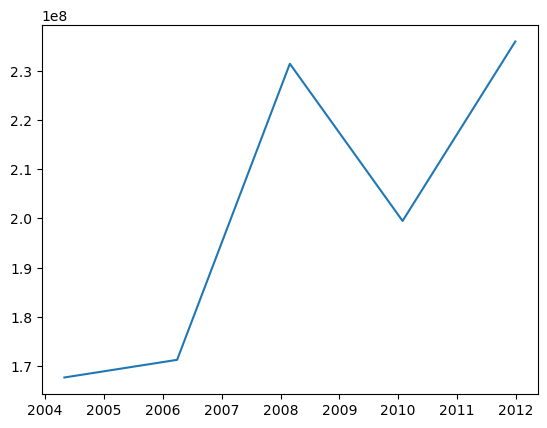

In [34]:
budget_coefficients = []

for name, group in importance_over_time_df_adjusted.groupby('release date'): 
    y = group[['adjusted_box_office_revenue']]
    X = group[['adjusted_budget' ]].copy()
    X.fillna(X.mean(), inplace=True)
    X = (X - X.mean()) / X.std()
    X = sm.add_constant(X)

    model = sm.OLS(y, X.astype(float))
    results = model.fit()
    if results.pvalues['adjusted_budget'] <= 0.05 and results.rsquared > 0.5: 
        print(f'R square = {results.rsquared}, year = {name.year}')
        budget_coefficients.append([name, results.params['adjusted_budget']])

plt.plot(np.array(budget_coefficients)[:, 0], np.array(budget_coefficients)[:, 1])

The initial idea was to find which were the most relevant feature for predicting the box office revenue through the years. The only feature which reliably had a significant coefficient was the budget, so we limited our analysis to that. What we find is that the coefficients for the budget steadily increase in the period between 2004 and 2012. This only indicates that while the budget stayed the same the average revenue increased in recent years. As we can see from the plot below even if real budget (inflation adjusted) stayed the same the box office revenue increased. 

Text(0.5, 1.0, 'Real movies budget over time')

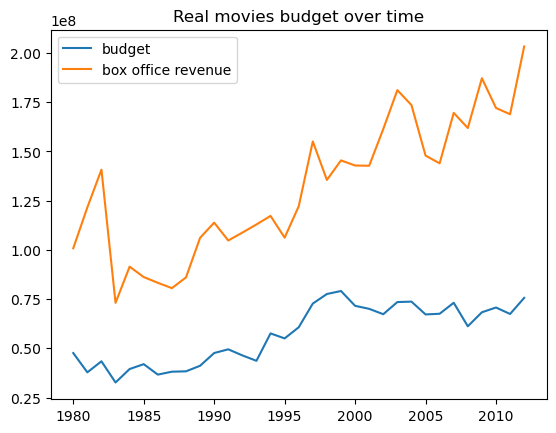

In [33]:
plt.plot(importance_over_time_df_adjusted.groupby('year')['adjusted_budget'].mean(), label='budget')
plt.plot(importance_over_time_df_adjusted.groupby('year')['adjusted_box_office_revenue'].mean(), label='box office revenue')
plt.legend()
plt.title('Real movies budget over time')

One interesting thing which can be concluded from the plots is that only after 2004 the budget gained a significant influence on the box office revenue, before the influence wasn't significant. To futher confirm that below are reported two regression, one on movies before 2004 and the other with movies after 2004. In the regression on the dataset year < 2004 we foudn a low R-square = 0.242, while on the dataset with year > 2004 R-quare = 0.538. This indicates that the correlation between budget and box office revenue became stronger in recent years (as the budget can explain more variance). Of course we can't conclude causation from this as there might be unmeasured counfouders. 

In [52]:
y = importance_over_time_df_adjusted[importance_over_time_df_adjusted.year < 2004].adjusted_box_office_revenue
X = importance_over_time_df_adjusted[importance_over_time_df_adjusted.year < 2004].adjusted_budget
X.fillna(X.mean(), inplace=True)
X = (X - X.mean()) / X.std()
X = sm.add_constant(X)

model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     adjusted_box_office_revenue   R-squared:                       0.242
Model:                                     OLS   Adj. R-squared:                  0.242
Method:                          Least Squares   F-statistic:                     970.9
Date:                         Thu, 14 Dec 2023   Prob (F-statistic):          3.61e-185
Time:                                 22:03:22   Log-Likelihood:                -62110.
No. Observations:                         3035   AIC:                         1.242e+05
Df Residuals:                             3033   BIC:                         1.242e+05
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/home/stefano/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [51]:
y = importance_over_time_df_adjusted[importance_over_time_df_adjusted.year > 2004].adjusted_box_office_revenue
X = importance_over_time_df_adjusted[importance_over_time_df_adjusted.year > 2004].adjusted_budget
X.fillna(X.mean(), inplace=True)
X = (X - X.mean()) / X.std()
X = sm.add_constant(X)

model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     adjusted_box_office_revenue   R-squared:                       0.538
Model:                                     OLS   Adj. R-squared:                  0.538
Method:                          Least Squares   F-statistic:                     1411.
Date:                         Thu, 14 Dec 2023   Prob (F-statistic):          2.22e-205
Time:                                 22:03:16   Log-Likelihood:                -24782.
No. Observations:                         1213   AIC:                         4.957e+04
Df Residuals:                             1211   BIC:                         4.958e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/home/stefano/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
